<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/AIPI540_IP_forpaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = False   # whether running on colab or locally on computer

In [2]:
if COLAB_FLAG:
    !pip install pydicom==2.1.2
    !pip install monai seaborn sentence_transformers
    !git clone 'https://github.com/mille055/AIPI540_individual_project.git'




In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
import scipy.stats as stats

warnings.filterwarnings("ignore")

/Users/cmm/opt/anaconda3/envs/aipi540/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/AIPI540_individual_project/scripts/')
    train_datafile = '/content/AIPI540_individual_project/data/trainfiles.csv'
    val_datafile = '/content/AIPI540_individual_project/data/valfiles.csv'
    test_datafile = '/content/AIPI540_individual_project/data/testfiles.csv'

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/AIPI540_individual_project/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'

### local imports ###
from scripts.config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from scripts.config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from scripts.config import sentence_encoder, series_description_column
from scripts.utils import *

from scripts.NLP.NLP_training import train_NLP_model
from scripts.NLP.NLP_inference import get_NLP_inference
from scripts.cnn.cnn_dataset import ImgDataset
from scripts.cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from scripts.cnn.cnn_model import CustomResNet50
from scripts.cnn.cnn_data_loaders import get_data_loaders
from scripts.metadata.meta_inference import meta_inference, calc_feature_importances
from scripts.metadata.meta_training import train_fit_parameter_trial, train_meta_model, evaluate_meta_model
from scripts.fusion_model.fus_model import FusionModel
from scripts.fusion_model.fus_inference import get_fusion_inference, get_fusion_inference_from_file
from scripts.fusion_model.fus_training import train_fusion_model, CustomDataset
from scripts.model_container import ModelContainer
from scripts.process_tree import Processor


# Load Datasets


In [8]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile)
#test_df

FileNotFoundError: [Errno 2] No such file or directory: '/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (35-68)/0052.dcm'

In [6]:
# prepares the features (preprocess normalizes/binarizes/ordinalizes the columns and limits to the feature set) and gets the labels

X_train_meta, scaler = preprocess(train_df, need_fit_scaler=True, save_scaler=True)

X_val_meta, _ = preprocess(val_df, scaler)
X_test_meta, _ = preprocess(test_df, scaler)
y_train = train_df.label
y_val = val_df.label
y_test = test_df.label


NameError: name 'train_df' is not defined

## Get Inferences from Saved Models

In [14]:
# Load the pickled model
with open(model_paths['meta'], 'rb') as file:
    meta_model = pickle.load(file)

with open(model_paths['scaler'], 'rb') as file:
    scaler = pickle.load(file)



In [41]:
# gets predictions, probabilitie, the truth label, and accuracies for the training, validation, and test datasets

Tpreds, Tprobs, Ty, Tacc = meta_inference(train_df, scaler, meta_model, feats_to_keep)
Vpreds, Vprobs, Vy, Vacc = meta_inference(val_df, scaler, meta_model, feats_to_keep)
TEpreds, TEprobs, TEy, TEacc = meta_inference(test_df, scaler, meta_model, feats_to_keep)


Preprocessing metadata for Random Forest classifier.
Have received 1369 entries.
Preprocessing metadata for Random Forest classifier.
Have received 354 entries.
Preprocessing metadata for Random Forest classifier.
Have received 432 entries.


In [42]:
# create dataframes from the data above

meta_train_results_df = make_results_df(Tpreds, Tprobs, Ty, train_df)
meta_val_results_df = make_results_df(Vpreds, Vprobs, Vy, val_df)
meta_test_results_df = make_results_df(TEpreds, TEprobs, TEy, test_df)
meta_vector = Tprobs

In [44]:



# bootstrap over the test samples for statitics
# Example usage:
# meta_acc_int, meta_f1_int, meta_f1_overall_int = bootstrap_results(meta_test_results_df, 'preds', 'true')


def bootstrap_results(df, preds, true, sample_fraction=0.5, num_samples=1000):
    # List of unique class labels in your data
    unique_classes = df[true].unique()

    # Initialize empty lists to store bootstrap statistics
    bootstrap_accuracy = []
    bootstrap_f1_score = []
    bootstrap_f1_scores = {class_label: [] for class_label in unique_classes}

    # Perform bootstrapping
    for _ in range(num_samples):
        # Generate a bootstrap sample by resampling the DataFrame with replacement
        bootstrap_sample = df.sample(n=int(sample_fraction * len(df)), replace=True)

        # Calculate accuracy and F1 score for the bootstrap sample
        accuracy = accuracy_score(bootstrap_sample[true], bootstrap_sample[preds])
        bootstrap_accuracy.append(accuracy)

        micro_avg_f1 = f1_score(bootstrap_sample[true], bootstrap_sample[preds], average='weighted')
        bootstrap_f1_score.append(micro_avg_f1)

        # Calculate F1 score for each class and store in a dictionary
        for class_label in unique_classes:
            true_values = (bootstrap_sample[true] == class_label).astype(int)
            predicted_values = (bootstrap_sample[preds] == class_label).astype(int)
            f1 = f1_score(true_values, predicted_values)
            bootstrap_f1_scores[class_label].append(f1)

    # Calculate the lower and upper percentiles for the accuracy confidence interval
    accuracy_interval = np.percentile(bootstrap_accuracy, [2.5, 97.5])
    f1_score_interval = np.percentile(bootstrap_f1_score, [2.5, 97.5])

    # Calculate confidence intervals for F1 scores for each class
    f1_scores_interval = {}
    for class_label in unique_classes:
        f1_scores = bootstrap_f1_score[class_label]
        f1_scores_interval[class_label] = np.percentile(f1_scores, [2.5, 97.5])

    # Calculate overall F1 score confidence intervals
    overall_f1_scores = [f1 for class_f1_scores in bootstrap_f1_scores.values() for f1 in class_f1_scores]
    print('overall_f1_scores:', overall_f1_scores)
    overall_f1_score_interval = np.percentile(overall_f1_scores, [2.5, 97.5])

    # Print the confidence intervals
    print("95% Confidence Interval for Accuracy:", accuracy_interval)
    print("95% Confidence Intervals for F1 Score: ", f1_score_interval)
    print("95% Confidence Interval for the Overall F1 scores:", overall_f1_score_interval)
    print("95% Confidence Intervals for F1 Scores (by class):")
    for class_label, interval in f1_scores_interval.items():
        print(f"Class {class_label}: {interval}")
    
    return accuracy_interval, f1_score_interval, overall_f1_score_interval, bootstrap_accuracy, bootstrap_f1_scores



In [45]:
# for metadata model only
meta_acc_int, meta_f1_int, meta_f1_overall_int, acc_list, f1_list = bootstrap_results(meta_test_results_df, 'preds', 'true')


overall_f1_scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [47]:
### statistics

acc_t_statistic, acc_p_value = stats.ttest_ind(acc_list, merged_acc_list)
print(acc_t_statistic, acc_p_value)


-0.04128174345917351 0.9670754118999478


In [48]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pix = CustomResNet50(19)

# Load the saved state dictionary
saved_state_dict = torch.load('../models/pixel_model_041623.pth', map_location=device)

# Modify the keys to add the 'resnet50.' prefix
modified_state_dict = {f'resnet50.{k}': v for k, v in saved_state_dict.items()}

# Load the modified state dictionary into the current model
model_pix.load_state_dict(modified_state_dict)
model_pix = model_pix.to(device)


In [37]:

#pixel_train_preds, pixel_train_probs = pixel_inference(model_pix, train_df.fname.tolist())
#pixel_val_preds, pixel_val_probs = pixel_inference(model_pix, val_df.fname.to_list())
pixel_test_preds, pixel_test_probs = pixel_inference(model_pix, test_df.fname.to_list())

FileNotFoundError: [Errno 2] No such file or directory: '/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm'

In [53]:
#pixel_train_results_df = make_results_df(pixel_train_preds, pixel_train_probs, Ty, train_df)
#pixel_val_results_df = make_results_df(pixel_val_preds, pixel_val_probs, Vy, val_df)
pixel_test_results_df = make_results_df(pixel_test_preds, pixel_test_probs, TEy, test_df)


                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.82      0.84      0.83        61
       dynamic_late       0.89      1.00      0.94        17
             t2 cor       1.00      1.00      1.00        22
                dwi       1.00      1.00      1.00        43
              t2 ax       1.00      0.98      0.99        42
          dixon_fat       1.00      1.00      1.00        29
   hepatobiliary ax       0.00      0.00      0.00        10
  hepatobiliary cor       1.00      0.33      0.50         3
        in_phase ax       1.00      0.83      0.90        23
dynamic_equilibrium       0.57      0.36      0.44        22
                loc       1.00      0.95      0.98        21
               mrcp       1.00      1.00      1.00        28
   opposed_phase ax       0.81      0.96      0.88        23
      portal_venous       0.43      0.75      0.55        20
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

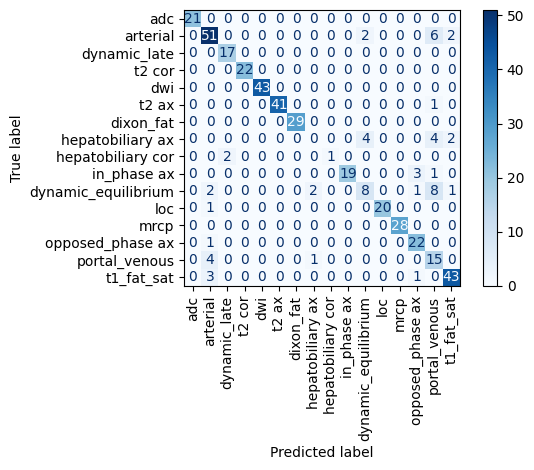

In [54]:
resnet50_results = display_and_save_results2(pixel_test_results_df.preds, pixel_test_results_df.true, fn='pixel', saveflag=False)

In [39]:

model_dense = load_pixel_model('../models/best_0606.pth', model_type='DenseNet')
model_dense.to(device)
dense_test_preds, dense_test_probs = pixel_inference(model_dense, test_df.fname.to_list())
dense_test_results_df = make_results_df(dense_test_preds, pixel_test_probs, TEy, test_df)
densenet_results = display_and_save_results2(dense_test_results_df.preds, dense_test_results_df.true, fn='dense', saveflag=True)

FileNotFoundError: [Errno 2] No such file or directory: '/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm'

In [52]:


#ds = pydicom.dcmread('/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm')
#ds = pydicom.dcmread('"/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm"')
ds = pydicom.dcmread('/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16\\ (1-40)/0021.dcm')


ds

FileNotFoundError: [Errno 2] No such file or directory: '/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16\\ (1-40)/0021.dcm'

In [67]:
cd 'volumes/cm7/'

/Volumes/cm7


In [68]:
ls

ls: .: Permission denied


In [64]:
cd '/volumes/cm7/Abdominal_MRI_dataset_split'

[Errno 2] No such file or directory: '/volumes/cm7/Abdominal_MRI_dataset_split'
/


In [65]:
ls

Applications/ Volumes/      etc@          sbin/
Library/      bin/          home@         tmp@
System/       cores/        opt/          usr/
Users/        dev/          private/      var@


In [59]:
ls

MacOnlineUpdateV31L39Up/              cm7/
Macintosh HD@                         cm7 1/
backup/                               com.apple.TimeMachine.localsnapshots/
backup 1/


In [69]:
dense_acc_int, dense_f1_int, dense_f1_overall_int, dense_acc_list, dense_f1_list = bootstrap_results(dense_test_results_df, 'preds', 'true')


overall_f1_scores: [0.9411764705882353, 1.0, 0.9032258064516129, 0.9523809523809523, 1.0, 0.9777777777777777, 0.9767441860465117, 0.9600000000000001, 0.9545454545454545, 1.0, 1.0, 1.0, 0.9189189189189189, 0.9811320754716981, 1.0, 0.9696969696969697, 0.9454545454545454, 0.8823529411764706, 1.0, 0.9500000000000001, 0.9545454545454545, 1.0, 0.9583333333333334, 1.0, 0.9767441860465117, 0.9787234042553191, 0.9696969696969697, 0.962962962962963, 0.9333333333333333, 1.0, 0.896551724137931, 0.9473684210526316, 0.9090909090909091, 0.9600000000000001, 0.9818181818181818, 0.962962962962963, 0.9767441860465117, 0.9268292682926829, 0.9767441860465117, 0.975609756097561, 1.0, 0.9795918367346939, 0.9787234042553191, 0.9090909090909091, 0.983050847457627, 0.975609756097561, 0.9811320754716981, 0.9545454545454545, 1.0, 0.9855072463768115, 0.9714285714285714, 0.9818181818181818, 0.9811320754716981, 0.9743589743589743, 0.8823529411764706, 0.9, 0.9787234042553191, 1.0, 0.962962962962963, 0.933333333333333

                     precision    recall  f1-score   support

                adc       1.00      1.00      1.00        21
           arterial       0.93      0.90      0.92        61
       dynamic_late       0.89      1.00      0.94        17
             t2 cor       1.00      1.00      1.00        22
                dwi       1.00      1.00      1.00        43
              t2 ax       1.00      1.00      1.00        42
          dixon_fat       1.00      1.00      1.00        29
   hepatobiliary ax       0.50      0.10      0.17        10
  hepatobiliary cor       1.00      0.33      0.50         3
        in_phase ax       0.96      0.96      0.96        23
dynamic_equilibrium       0.58      0.82      0.68        22
                loc       1.00      1.00      1.00        21
               mrcp       1.00      1.00      1.00        28
   opposed_phase ax       0.96      1.00      0.98        23
      portal_venous       0.71      0.75      0.73        20
         t1_fat_sat    

<Figure size 2500x2500 with 0 Axes>

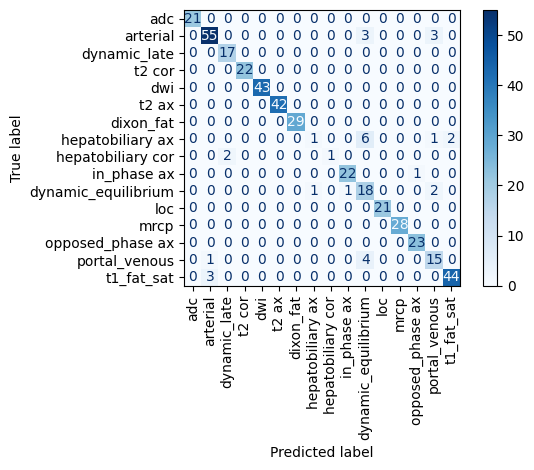

In [70]:
### going to create the preds and probs for the densenet model data combining for meta<70

dense70_df = dense_test_results_df.copy()
dense70_df['dense_preds'] = dense70_df['preds']
dense70_df = dense70_df.drop('preds', axis=1)
dense70_df = dense70_df.drop('probs', axis=1)
dense70_df = meta_test_results_df.merge(dense70_df, how = 'left', on = ['series', 'patientID'])
dense70_df['meta_confidence'] = dense70_df['probs'].apply(lambda x: max(x))
dense70_df.loc[dense70_df['meta_confidence'] < 0.7, 'preds'] = dense70_df['dense_preds']
dense70_df.preds = dense70_df.preds.astype('int')
densenet70_results = display_and_save_results2(dense70_df.preds, dense70_df.true_x, fn='dense70', saveflag=True)

In [71]:
# for densenet for meta<70
dense70_acc_int, dense70_f1_int, dense70_f1_overall_int, dense70_acc_list, dense70_f1_list = bootstrap_results(dense70_df, 'preds', 'true_x')


overall_f1_scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [ ]:
dense70_acc_t_statistic, dense70_acc_p_value = stats.ttest_ind(meta_acc_int, dense70_acc_int)
#f1_t_statistic, f1_p_value = stats.ttest_ind(meta_f1_int, merged_f1_int)
print(acc_t_statistic, acc_p_value)

-0.6275716324421876 0.5943838987492857


### Getting NLP inference


In [19]:
# Load the pickled model
with open('../models/text_model20230415.st', 'rb') as file:
    NLP_model = pickle.load(file)

In [20]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
senttrans_model = SentenceTransformer(sentence_encoder, device=device)



In [21]:
#from NLP.NLP_training import train_NLP_model
train_preds, train_probs, train_acc, val_preds, val_probs, val_acc, test_preds, test_probs, test_acc, text_model_T = train_NLP_model(train_df, val_df, test_df, senttrans_model=senttrans_model)
print(train_acc, val_acc, test_acc)

Accuracy on the training set is 0.953
size of preds_val is  354
Accuracy on the val set is 0.960
Accuracy on the test set is 0.963
0.9525200876552228 0.96045197740113 0.9629629629629629


In [22]:
# testing on a single row
#from NLP.NLP_inference import get_NLP_inference
get_NLP_inference(NLP_model, filenames = [train_df.fname[0]])

/volumes/cm7/Abdominal_MRI_dataset_split/train/104/exam1/18 (35-68)/0052.dcm


(array([8]),
 array([2.05831172e-02, 1.09033989e-02, 9.21969543e-04, 1.18682737e-03,
        8.91965128e-01, 2.32301892e-02, 3.88250318e-04, 1.11549417e-02,
        2.69172170e-03, 8.54711487e-04, 5.62694850e-03, 3.48057180e-04,
        4.63554801e-03, 2.39544011e-03, 2.17179612e-03, 7.22290166e-03,
        3.47885989e-04, 3.88036192e-03, 9.49080476e-03]))

In [23]:

nlp_test_preds, nlp_test_probs = get_NLP_inference(NLP_model, test_df.fname.tolist())
# #nlp_train_preds, nlp_train_probs = get_NLP_inference(NLP_model, train_df.fname.tolist())
# #nlp_val_preds, nlp_val_probs = get_NLP_inference(NLP_model, val_df.fname.tolist())


/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/1/0007.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/10/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/19/0045.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/8/0017.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/4/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/15/0001.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/3/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_spli

In [24]:
print(classification_report(nlp_test_preds, TEy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.98      0.95      0.97        63
           6       1.00      0.85      0.92        20
           7       1.00      0.96      0.98        23
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        42
          11       0.86      1.00      0.93        25
          12       0.60      1.00      0.75         6
          13       0.00      0.00      0.00         0
          14       1.00      1.00      1.00        23
          16       1.00      0.81      0.90        27
          17       1.00      1.00      1.00        21
          18       0.96      1.00      0.98        27
          19       1.00      1.00      1.00        23
          23       1.00      0.91      0.95        22
          25       0.94      0.96      0.95        46

    accuracy                           0.96       432
   macro avg       0.90   

In [25]:
# nlp_train_results_df = make_results_df(nlp_train_preds, nlp_train_probs, Ty, train_df)
# nlp_val_results_df = make_results_df(nlp_val_preds, nlp_val_probs, Vy, val_df)
nlp_test_results_df = make_results_df(nlp_test_preds, nlp_test_probs, TEy, test_df)

# #change names of preds, probs
# for frame_df in [nlp_train_results_df, nlp_val_results_df, nlp_test_results_df]:
# #    frame_df.rename(columns={'preds':'nlp_preds', 'probs':'nlp_probs'}, inplace=True)


## Create fusion model

In [154]:
# loading the data back from pickled dataframes
with open('../data/fusion_train.pkl', 'rb') as file:
    ftrain = pd.read_pickle(file)

with open('../data/fusion_val.pkl', 'rb') as file:
    fval = pd.read_pickle(file)

with open('../data/fusion_test.pkl', 'rb') as file:
    ftest = pd.read_pickle(file)

#adjust the labels to consecutive numbers 0-18 and storing the original labels into 'class'
ftest['class'] = ftest['true']
ftrain['class'] = ftrain['true']
fval['class'] = fval['true']

ftest['true'] = ftest['true'].apply(lambda x: classes.index(x))
ftrain['true'] = ftrain['true'].apply(lambda x: classes.index(x))
fval['true'] = fval['true'].apply(lambda x: classes.index(x))

In [155]:




# get model container for the base models
model_container=ModelContainer()
model_containerDense = ModelContainer()
model_containerDense.cnn_model = model_dense

#  Instantiate FusionModel
fusion_model = FusionModel(model_containerDense, pretrained=False)
fusion_model_no_nlp = FusionModel(model_containerDense, pretrained=False, include_nlp=False)


# Define the loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fusion_model.parameters(), lr=0.001)
p_optimizer = optim.Adam(fusion_model_no_nlp.parameters(), lr=0.001)


train_dataset = CustomDataset(ftrain)
val_dataset = CustomDataset(fval)
test_dataset = CustomDataset(ftest)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)




In [156]:

# already have the trained model with all 3 modalities

trained_model, training_history_with_nlp = train_fusion_model(fusion_model, train_loader, val_loader, test_loader, device, optimizer, loss_fn = criterion, num_epochs=30, include_nlp=True)

# save trained model
model_weights_path = '../models/fusion_model_weightsDense' + datetime.today().strftime('%Y%m%d')+'.pth'
torch.save(trained_model.state_dict(), model_weights_path)

Epoch 1/30
----------
Train Loss: 2.8783 Acc: 0.1468
Validation Loss: 2.7832 Acc: 0.2881
Epoch 2/30
----------
Train Loss: 2.6889 Acc: 0.4580
Validation Loss: 2.6109 Acc: 0.7062
Epoch 3/30
----------
Train Loss: 2.5063 Acc: 0.7487
Validation Loss: 2.4458 Acc: 0.7542
Epoch 4/30
----------
Train Loss: 2.3303 Acc: 0.8305
Validation Loss: 2.2868 Acc: 0.7966
Epoch 5/30
----------
Train Loss: 2.1615 Acc: 0.9306
Validation Loss: 2.1351 Acc: 0.8757
Epoch 6/30
----------
Train Loss: 2.0004 Acc: 0.9620
Validation Loss: 1.9909 Acc: 0.8870
Epoch 7/30
----------
Train Loss: 1.8469 Acc: 0.9708
Validation Loss: 1.8541 Acc: 0.8898
Epoch 8/30
----------
Train Loss: 1.7023 Acc: 0.9715
Validation Loss: 1.7243 Acc: 0.8898
Epoch 9/30
----------
Train Loss: 1.5659 Acc: 0.9766
Validation Loss: 1.6040 Acc: 0.8955
Epoch 10/30
----------
Train Loss: 1.4391 Acc: 0.9795
Validation Loss: 1.4918 Acc: 0.9011
Epoch 11/30
----------
Train Loss: 1.3213 Acc: 0.9832
Validation Loss: 1.3884 Acc: 0.9040
Epoch 12/30
-------

In [157]:
# already have the trained model, will get from storage
#
trained_model_no_nlp, training_history_without_nlp = train_fusion_model(fusion_model_no_nlp, train_loader, val_loader, test_loader, device, p_optimizer, loss_fn=criterion, num_epochs=30, include_nlp=False)

# save trained model
model_weights_path_no_nlp = '../models/fusion_model_weights_no_nlpDense'+datetime.today().strftime('%Y%m%d')+'.pth'
torch.save(trained_model_no_nlp.state_dict(), model_weights_path_no_nlp)

Epoch 1/30
----------
Train Loss: 2.8727 Acc: 0.1366
Validation Loss: 2.8197 Acc: 0.2797
Epoch 2/30
----------
Train Loss: 2.7322 Acc: 0.5084
Validation Loss: 2.6964 Acc: 0.6186
Epoch 3/30
----------
Train Loss: 2.5966 Acc: 0.7546
Validation Loss: 2.5765 Acc: 0.7147
Epoch 4/30
----------
Train Loss: 2.4639 Acc: 0.8064
Validation Loss: 2.4593 Acc: 0.7712
Epoch 5/30
----------
Train Loss: 2.3348 Acc: 0.8554
Validation Loss: 2.3454 Acc: 0.8164
Epoch 6/30
----------
Train Loss: 2.2093 Acc: 0.9335
Validation Loss: 2.2358 Acc: 0.8616
Epoch 7/30
----------
Train Loss: 2.0879 Acc: 0.9489
Validation Loss: 2.1295 Acc: 0.8644
Epoch 8/30
----------
Train Loss: 1.9710 Acc: 0.9584
Validation Loss: 2.0276 Acc: 0.8672
Epoch 9/30
----------
Train Loss: 1.8588 Acc: 0.9642
Validation Loss: 1.9302 Acc: 0.8701
Epoch 10/30
----------
Train Loss: 1.7510 Acc: 0.9657
Validation Loss: 1.8370 Acc: 0.8701
Epoch 11/30
----------
Train Loss: 1.6483 Acc: 0.9722
Validation Loss: 1.7477 Acc: 0.8757
Epoch 12/30
-------

In [ ]:
# accuracy_fusion = np.mean(comparison_fusion_df.preds==comparison_fusion_df.true)
# accuracy_fusion_no_nlp = np.mean(comparison_fusion_df.preds_no_nlp==comparison_fusion_df.true)
# print('Accuracy of the fusion model including nlp: ', np.round(accuracy_fusion, 3))
# print('Accuracy of the model without nlp is :', np.round(accuracy_fusion_no_nlp, 3))


In [159]:
# going to load from scratch and get predictions
# Instantiate your models
#model_container = ModelContainer()

Fmodel = FusionModel(model_containerDense)
Fmodel_no_nlp = FusionModel(model_containerDense, include_nlp=False)

# Load the saved state_dict (model weights)
saved_model_weights = torch.load('../models/fusion_model_weightsDense20230919.pth')
saved_model_weights_no_nlp = torch.load('../models/fusion_model_weights_no_nlpDense20230919.pth')

# Load the state_dict into the model
Fmodel.load_state_dict(saved_model_weights)
Fmodel_no_nlp.load_state_dict(saved_model_weights_no_nlp)


<All keys matched successfully>

In [160]:



def compare_fusion_models(data, y_true, fus_model1, fus_model2):

    # Set the model to evaluation mode
    fus_model1.eval()
    fus_model2.eval()


    predictions1 = []
    probs1 = []

    predictions2 = []
    probs2 = []


    for index, row in data.iterrows():
        pred1, prob1, ts_df1 = fus_model1.get_fusion_inference(row)
        predictions1.append(pred1)
        probs1.append(prob1)


        pred2, prob2, ts_df2 = fus_model2.get_fusion_inference(row)
        predictions2.append(pred2)
        probs2.append(prob2)

    comparison_fusion_df = pd.DataFrame({'preds': predictions1, 'probs': probs1, 'preds2': predictions2, 'probs2': probs2, 'true': TEy})
    accuracy1 = np.mean(comparison_fusion_df.preds==comparison_fusion_df.true)
    accuracy2 = np.mean(comparison_fusion_df.preds2== comparison_fusion_df.true)

    print('The accuracies of models 1 and 2 are: ', np.round(accuracy1,3), np.round(accuracy2,3))


    return comparison_fusion_df, accuracy1, accuracy2, predictions1, predictions2


In [161]:
comparison_df, acc1, acc2, pred1, pred2 = compare_fusion_models(X_test_meta, TEy, Fmodel, Fmodel_no_nlp)

/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (1-40)/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/16 (41-80)/0061.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/18/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/11/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/7/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/6/0037.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal_MRI_dataset_split/test/102/exam1/17/0021.dcm
/volumes/cm7/Abdominal

In [34]:
print(acc1, acc2)
print(comparison_df.head())

0.9560185185185185 0.9236111111111112
   preds     probs  preds2    probs2  true
0      8  0.852390       8  0.722339     8
1      8  0.852317       8  0.722180     8
2     16  0.492845      16  0.290857    16
3      2  0.635412       2  0.406623     2
4     25  0.829992      25  0.722697    25


In [162]:
### getting results for the nlp fusion test for display
fusion_results_df = dense_test_results_df.copy()
fusion_results_df['fusion_preds'] = comparison_df['preds2'].values



,preds,true,probs,patientID,series_description,series,contrast,plane,fusion_preds
0,8,8,"[5.295005848893197e-06, 2.5784959234442795e-06, 1.871971335276612e-06, 2.8697016318801616e-07, 0.9995385408401489, 0.0004020421765744686, 1.518843987469154e-06, 8.767859981162474e-06, 2.662447968759807e-06, 4.322704626247287e-06, 1.3077354878987535e-06, 8.256866408373753e-07, 3.3850503768917406e-06, 3.85517205359065e-06, 1.1364853889972437e-05, 3.017984681719099e-06, 9.718829687699326e-07, 5.70565191537753e-07, 6.8958347583247814e-06]",102,ax diff_TRACEW,16(1-40),1,ax,8
1,8,8,"[7.795669262122829e-06, 3.77051804889561e-07, 1.3306873825058574e-06, 5.689631734639988e-07, 0.999536395072937, 0.00036113738315179944, 1.920655677167815e-06, 3.905836820194963e-06, 2.2699914552504197e-06, 3.9697292777418625e-06, 5.590991349890828e-06, 9.76624164650275e-07, 6.624837169511011e-06, 4.107923359697452e-06, 1.0245211342407856e-05, 1.4333796571008861e-05, 9.867979997579823e-07, 6.653008313151076e-07, 3.680178997456096e-05]",102,ax diff_TRACEW,16(41-80),1,ax,8
2,16,16,"[3.5558165109250695e-05, 0.004637621343135834, 0.00029105349676683545, 2.3344089640886523e-05, 7.508293947466882e-06, 0.00012146478547947481, 4.7697481932118535e-05, 0.001694856327958405, 0.6417149901390076, 0.0013481216738000512, 3.7309314393496606e-06, 3.447082781349309e-05, 0.00756780756637454, 9.920371439875453e-07, 0.0008502845885232091, 6.070011295378208e-05, 5.1285078370710835e-05, 0.3310074210166931, 0.01050104945898056]",102,ax equilibrium new,18,1,ax,16
3,2,2,"[4.33954774052836e-05, 0.9682928919792175, 0.0002057523961411789, 1.5103199984878302e-05, 0.00016014174616429955, 0.00031231247703544796, 8.913494093576446e-05, 6.265478441491723e-05, 0.0010500579373911023, 0.0003332729684188962, 2.1993811969878152e-05, 4.733460446004756e-05, 0.0007732525118626654, 0.00015629710105713457, 6.668644346063957e-05, 0.0004423663194756955, 3.7639125366695225e-05, 0.00853574275970459, 0.019353967159986496]",102,ax dyn new,11,1,ax,2
4,25,25,"[1.6286387563013704e-06, 0.002541319001466036, 1.7130394098785473e-06, 9.334833066532155e-07, 5.632040938507998e-06, 2.3475324269384146e-05, 3.28775126945402e-06, 1.3577317076851614e-05, 0.0001314869150519371, 1.2296535714995116e-05, 1.4450525668507908e-05, 1.3575264574683388e-06, 3.3449955481046345e-06, 7.983420800883323e-06, 4.035400706925429e-06, 4.4944084947928786e-05, 1.6027393030526582e-06, 1.5534296835539863e-06, 0.9971852898597717]",102,ax dixon_W,7,0,ax,25
...,...,...,...,...,...,...,...,...,...
427,8,8,"[1.6788677385193296e-05, 0.00011456928768893704, 1.9850658645736985e-06, 3.967888915212825e-06, 0.9995980858802795, 4.174047717242502e-05, 9.187433533952571e-06, 2.227090772066731e-05, 6.412235507013975e-06, 9.538634913042188e-06, 3.111479236395098e-05, 3.107758857368026e-06, 9.542838597553782e-06, 4.525854819803499e-05, 2.0366482203826308e-05, 1.3505541573977098e-05, 3.545582558217575e-06, 5.048510047345189e-06, 4.406617517815903e-05]",58,ax diff_TRACEW,16(1-36),1,ax,8
428,7,7,"[3.0261264782893704e-07, 1.492674925884785e-07, 0.0001412155106663704, 0.9997287392616272, 1.1134382020827616e-06, 6.25413986199419e-06, 1.1435249689384364e-06, 6.164690375953796e-07, 1.7378543759605236e-07, 6.320663669612259e-05, 1.9821477792447695e-07, 1.0693768217606703e-06, 1.7542804471304407e-06, 1.3705421224585734e-05, 3.6155321140540764e-05, 4.974012881575618e-07, 1.4771662790735718e-06, 2.2252957023738418e-06, 4.588561353102705e-08]",58,cor haste,2,0,cor,7
429,2,2,"[4.183460475815082e-07, 0.9992997646331787, 3.8057089568610536e-06, 9.690791102912044e-07, 1.6746191249694675e-05, 4.2676157363530365e-07, 1.6618303106952226e-06, 2.9860359518352197e-06, 3.048866165045183e-05, 5.760902695328696e-06, 1.218046321582733e-07, 6.274550514717703e-07, 6.595204240511521e-07, 9.827580470300745e-06, 1.7112515706685372e-06, 6.2139088186086155e-06, 5.865717298547679e-07, 0.0001289883948629722, 0.0004884692025370896]",58,ax dyn new,13,1,ax,2
430,14,14,"[1.3646952083945507e-06, 7.470232503692

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.92      0.90      0.91        61
           6       0.85      1.00      0.92        17
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        43
           9       1.00      1.00      1.00        42
          11       1.00      0.97      0.98        29
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         3
          14       1.00      1.00      1.00        23
          16       0.54      0.91      0.68        22
          17       1.00      0.95      0.98        21
          18       1.00      1.00      1.00        28
          19       0.92      1.00      0.96        23
          23       0.67      0.60      0.63        20
          25       1.00      0.96      0.98        47

    accuracy                           0.92       432
   macro avg       0.81   

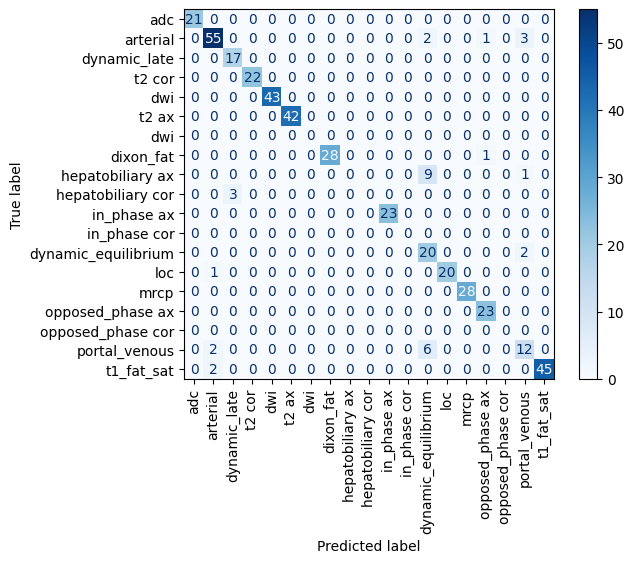

<Figure size 2500x2500 with 0 Axes>

In [163]:
fusion_ = display_and_save_results(fusion_results_df.fusion_preds, fusion_results_df.true, fn='fusion_no_nlp', saveflag=True)

In [ ]:
# num_epochs = 20
# batch_size = 32

# for epoch in range(num_epochs):
#     for i in range(0, len(y_train_fusion), batch_size):
#         actual_batch_size = min(batch_size, len(Xtrain1) - i)
#         X1_batch = torch.tensor(np.array(Xtrain1[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
#         X2_batch = torch.tensor(np.array(Xtrain2[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
#         #X3_batch = torch.tensor(np.array(Xtrain3[i:i+actual_batch_size], dtype=np.float32), dtype=torch.float32)
#         y_batch = torch.tensor(y_train_fusion[i:i+actual_batch_size], dtype=torch.long)

#         # print(f"X1_batch shape: {X1_batch.shape}")
#         # print(f"X2_batch shape: {X2_batch.shape}")
#         # print(f"X3_batch shape: {X3_batch.shape}")
#         # print(f"y_batch shape: {y_batch.shape}")


#         p_optimizer.zero_grad()
#         outputs = meta_and_pixel_fusion_model(X1_batch, X2_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         p_optimizer.step()

#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


In [ ]:
# import torch.nn.functional as F
# # Evaluate the model with the test data
# with torch.no_grad():
#     X1_test_t = torch.tensor(Xtest1, dtype=torch.float32)
#     X2_test_t = torch.tensor(Xtest2, dtype=torch.float32)
#     #X3_test_t = torch.tensor(Xtest3, dtype=torch.float32)
#     y_test_t = torch.tensor(y_test_fusion, dtype=torch.long)

#     outputs = meta_and_pixel_fusion_model(X1_test_t, X2_test_t)
#     g_probabilities = F.softmax(outputs, dim=1)  # Apply softmax to the outputs

#     _, g_predicted = torch.max(outputs, 1)
#     correct = (g_predicted == y_test_t).sum().item()
#     g_accuracy = correct / len(y_test_t) * 100

# print(f'Test accuracy: {g_accuracy}%')

In [ ]:
# # for classification report and CM:
# # Move the tensor to the CPU if it's on the GPU
# if g_predicted.is_cuda:
#     g_predicted = g_predicted.cpu()
# g_predicted_list = g_predicted.tolist()
# g_predictions = [classes[g] for g in g_predicted_list]


In [ ]:
# label_list = [abd_label_dict[str(x)]['short'] for x in actual_classes]
# label_list

In [ ]:
# print(classification_report(g_predictions, TEy, labels = actual_classes, target_names = label_list))

In [ ]:
# def duplicated_cm_plot(ytrue, ypreds, classes, fname):

#     cm = confusion_matrix(ytrue, ypreds, labels=classes)
#     plt.figure(figsize=(25, 25))
#     plt.tight_layout()
#     ConfusionMatrixDisplay(cm, display_labels=[abd_label_dict[str(x)]['short'] for x in classes]).plot(xticks_rotation = 'vertical', cmap='Blues')
#     plt.savefig(fname + datetime.now().strftime('%Y%m%d') + ".png", dpi=300, bbox_inches='tight')

#     plt.show()

#     return plt


In [ ]:
# g_cm = duplicated_cm_plot(TEy,g_predictions, actual_classes, '../assets/figures/FigFusionMetaPixel')

In [ ]:
# # for classification report and CM:
# # Move the tensor to the CPU if it's on the GPU
# if f_predicted.is_cuda:
#     f_predicted = f_predicted.cpu()
# f_predicted_list = f_predicted.tolist()
# f_predictions = [classes[f] for f in f_predicted_list]


In [ ]:
# f_cm = duplicated_cm_plot(TEy,f_predictions, actual_classes, '../assets/figures/FigFusionAll')

In [ ]:
# # Save the trained fusion models to a file
# with open('fusion_model041623.pkl', 'wb') as f:
#     pickle.dump(fusion_model, f)

In [ ]:
# # Save the trained fusion models to a file
# with open('meta_and_pixel_fusion_model041623.pkl', 'wb') as f:
#     pickle.dump(meta_and_pixel_fusion_model, f)

# Inference fusion model

In [150]:
## testing the version that accepts the dataframe row

sample = X_test_meta.iloc[100]
model_container = ModelContainer()
new_fusion_model = FusionModel(model_container)

preds, probs, tshootdf = new_fusion_model.get_fusion_inference(sample)
print(preds)

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/11/0037.dcm
25


In [ ]:
# ## testing the version that accepts the filename

# samplefname = X_test_meta.iloc[100].fname
# print(samplefname)
# model_container = ModelContainer()
# new_fusion_model = FusionModel(model_container)

# preds, probs, tshootdf = get_fusion_inference_from_file(str(samplefname), model_container)
# print(preds)

/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/11/0037.dcm
Preprocessing metadata for Random Forest classifier.
Have received 1 entries.
[25]


AttributeError: 'str' object has no attribute 'values'

In [ ]:
# my_dcm = dcmread(samplefname)

In [ ]:
# my_dc_df = pd.DataFrame.from_dicoms([samplefname])
# my_dc_df

,ImageType,SOPClassUID,SeriesDescription,BodyPartExamined,ScanningSequence,SequenceVariant,ScanOptions,MRAcquisitionType,AngioFlag,SliceThickness,...,EchoTrainLength,StudyInstanceUID,SeriesInstanceUID,SeriesNumber,AcquisitionNumber,InstanceNumber,ImageOrientationPatient,PhotometricInterpretation,PixelSpacing,fname
0,"[ORIGINAL, PRIMARY, M, NORM, DIS2D]",MR Image Storage,ax vibe pre,ABDOMEN,GR,SP,"[PFP, FS]",3D,N,4.0,...,1,3.8.6.0.5.3.26621.2.1.1.2572075177465224110561527068556,7.5.2.0.8.8.54817.2.1.1.00164780318831646424456765767141,11,1,37,"[0.99919439510787, 2e-016, -0.0401317926963, -2e-016, 1, 0]",MONOCHROME2,"[0.7421875, 0.7421875]",/volumes/cm7/Abdominal_MRI_dataset_split/test/071/exam1/11/0037.dcm
